In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Trust Region Dogleg Method for Optimization:
# The Trust Region (TR) method is used for optimizing a non-linear function by approximating
# it with a quadratic model within a defined radius or "trust region". The Dogleg approach
# is a specific strategy to find the step direction within the TR, combining steepest descent
# and Newton's direction.

# Steps:
# 1. Initialize parameters: starting point, trust region radius, and iteration limit.
# 2. Construct a model of the objective function at each iteration.
# 3. Compute the steepest descent direction and Newton's step.
# 4. Use the Dogleg method to select a step within the trust region:
#    - If Newton's step is within the TR, use it.
#    - else use steepest descent direction
# 5. Evaluate the model's accuracy and adjust the TR radius accordingly.
# 6. Update the position if the step improves the objective function.
# 7. Repeat until convergence.

class TrustRegionDogleg:
    def __init__(self, epsilon=1e-6, max_iterations=100, eta=0.2, r0=1.0, rmax=10.0):
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.eta = eta  # Threshold to accept the step
        self.r0 = r0  # Initial trust region radius
        self.rmax = rmax  # Maximum allowed trust region radius
        self.x_history = []
        self.cost_history = []
        self.radius_history = []

    def cost_function(self, x):
        # Rosenbrock's valley
        a = 1
        b = 100
        return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

    def gradient(self, x):
        # Gradient of the Rosenbrock function
        a = 1
        b = 100
        grad = np.zeros_like(x)
        grad[0] = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)
        grad[1] = 2 * b * (x[1] - x[0]**2)
        return grad

    def hessian(self, x):
        # Hessian of the Rosenbrock function
        a = 1
        b = 100
        H = np.zeros((2, 2))
        H[0, 0] = 2 - 4 * b * (x[1] - x[0]**2) + 8 * b * x[0]**2
        H[0, 1] = H[1, 0] = -4 * b * x[0]
        H[1, 1] = 2 * b
        return H

    def fit(self, initial_x):
        x = initial_x
        r = self.r0
        k = 0
        grad = self.gradient(x)

        while np.linalg.norm(grad) > self.epsilon and k < self.max_iterations:
            grad = self.gradient(x)
            H = self.hessian(x)

            psd = -grad / np.linalg.norm(grad)

            # Newton's step (solving H pnt = -grad)
            pnt = -np.linalg.solve(H, grad)

            # Dogleg strategy to find step pk
            if np.linalg.norm(pnt) <= r:
                pk = pnt  # Use Newton's step if within trust region
            elif np.linalg.norm(psd) >= r:
                pk = (r / np.linalg.norm(psd)) * psd  # Use steepest descent
            else:
                # Compute tau such that psd + tau (pnt - psd) = r
                diff = pnt - psd
                a = np.dot(diff, diff)
                b = 2 * np.dot(psd, diff)
                c = np.dot(psd, psd) - r**2
                tau = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
                pk = psd + tau * diff  # Combination of psd and pnt

            # Compute reduction
            f_old = self.cost_function(x)
            f_new = self.cost_function(x + pk)
            predicted_reduction = -np.dot(grad, pk) - 0.5 * np.dot(pk, np.dot(H, pk))
            rho = (f_old - f_new) / predicted_reduction

            # Update trust region radius
            if rho < 0.25:
                r *= 0.25
            elif rho > 0.75 and np.linalg.norm(pk) == r:
                r = min(2 * r, self.rmax)

            if rho > self.eta:
                x = x + pk

            self.x_history.append(x.copy())
            self.cost_history.append(f_new)
            self.radius_history.append(r)
            k += 1

        return x

    def plot_results(self):
        x_vals = np.array(self.x_history)
        x1 = np.linspace(-2, 2, 100)
        x2 = np.linspace(-1, 3, 100)
        X1, X2 = np.meshgrid(x1, x2)
        Z = (1 - X1)**2 + 100 * (X2 - X1**2)**2

        fig, ax = plt.subplots(1, 4, figsize=(24, 6))

        # Plot cost function evolution
        ax[0].plot(self.cost_history, color='blue', marker='o')
        ax[0].set_title("Cost Function Evolution")
        ax[0].set_xlabel("Iterations")
        ax[0].set_ylabel("Cost Function Value")
        ax[0].grid(True)

        # Plot trust region radius evolution
        ax[1].plot(self.radius_history, color='green', marker='s')
        ax[1].set_title("Trust Region Radius Evolution")
        ax[1].set_xlabel("Iterations")
        ax[1].set_ylabel("Radius")
        ax[1].grid(True)

        # Plot optimization path on the contour of the Rosenbrock function
        ax[2].contour(X1, X2, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')
        ax[2].plot(x_vals[:, 0], x_vals[:, 1], 'r-x', label="Optimization Path")
        ax[2].set_title("Optimization Path on Rosenbrock Function Contour")
        ax[2].set_xlabel("x1")
        ax[2].set_ylabel("x2")
        ax[2].legend()
        ax[2].grid(True)

        # Plot 3D surface plot of the Rosenbrock function with the optimization path
        ax3 = fig.add_subplot(144, projection='3d')
        ax3.view_init(elev=30, azim=-60)
        ax3.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.8)
        ax3.plot(
            [x[0] for x in self.x_history],
            [x[1] for x in self.x_history],
            [self.cost_function(x) for x in self.x_history],
            color='r', marker='x', markersize=5, linestyle='-', linewidth=3, label="Optimization Path"
        )
        ax3.set_title('3D Surface of Rosenbrock Function with Optimization Path')
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('f(x1, x2)')
        ax3.legend()

        plt.tight_layout()
        plt.show()

Optimized x: [1. 1.]


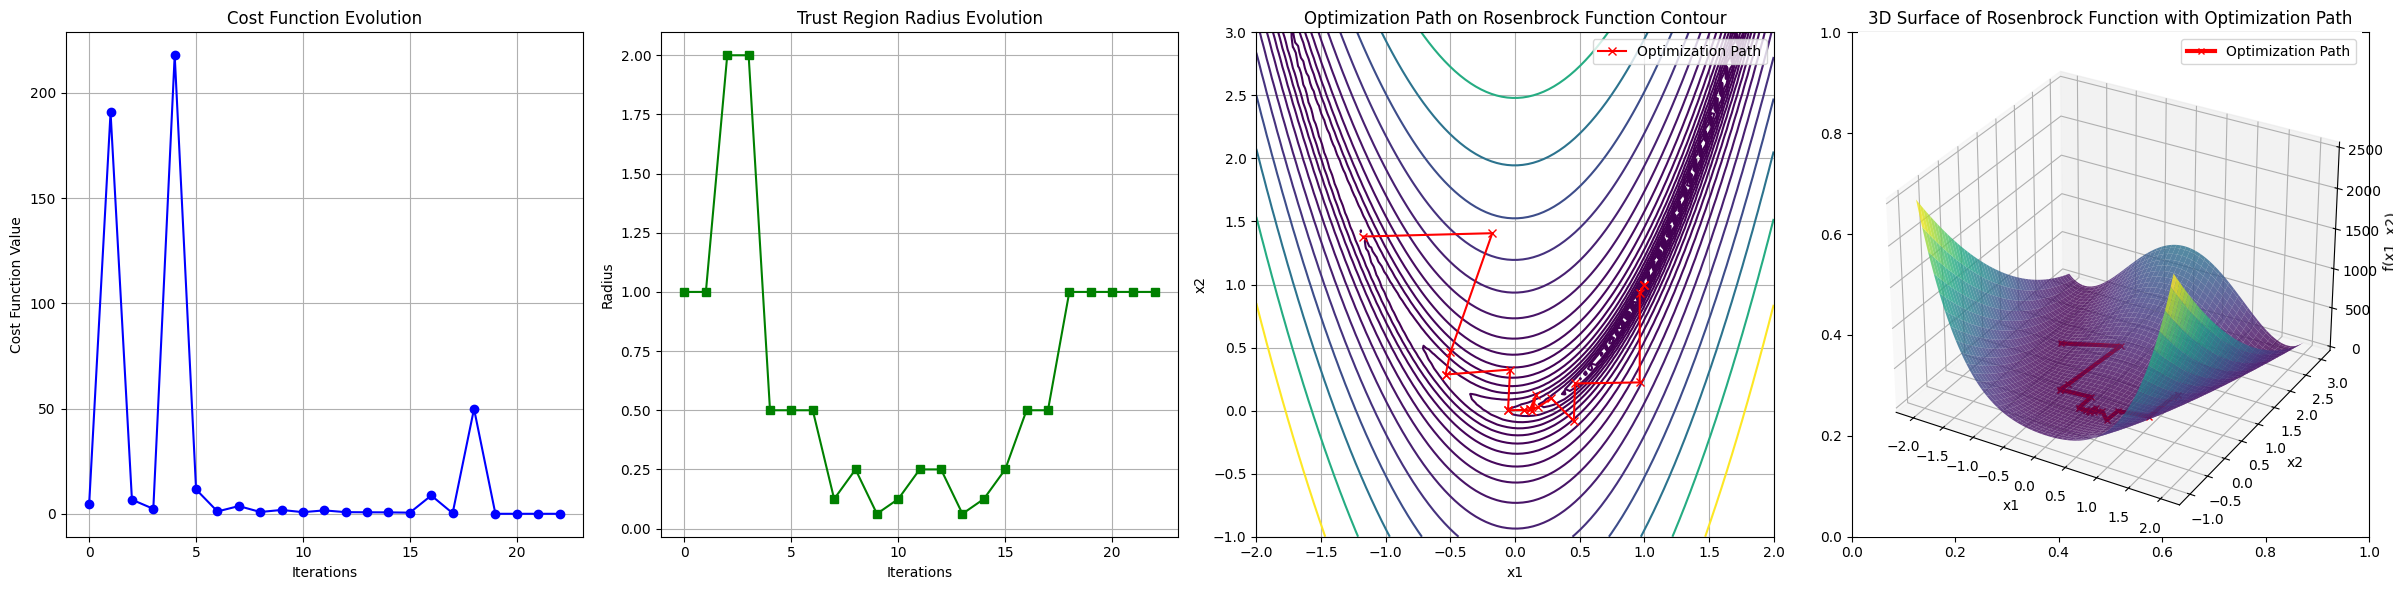

In [13]:
if __name__ == "__main__":
    optimizer = TrustRegionDogleg()
    initial_x = np.array([-1.2, 1.0])  # Initial guess
    optimized_x = optimizer.fit(initial_x)

    print("Optimized x:", optimized_x)

    # Plot the results
    optimizer.plot_results()